#### For Colab

In [1]:
"""
function ClickConnect(){
    console.log("Working");
    document.querySelector("colab-toolbar-button").click() 
}
var i = setInterval(ClickConnect, 900000)
clearInterval(i)
"""

'\nfunction ClickConnect(){\n    console.log("Working");\n    document.querySelector("colab-toolbar-button").click() \n}\nvar i = setInterval(ClickConnect, 900000)\nclearInterval(i)\n'

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
drive_dir = '/content/drive/My Drive/MAGMA: Summarization/'

#### Install Libraries

In [4]:
!pip install transformers==4.1.1
!pip install -U sentencepiece!=0.1.92
!pip install -U datasets
!pip install rouge_score

     |████████████████████████████████| 1.5MB 7.1MB/s 
     |████████████████████████████████| 2.9MB 35.3MB/s 
     |████████████████████████████████| 890kB 54.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=274935719e07f0c6d4758c81d3c7ecd767edfe9aafa1554ea366f5670698c9ab
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 1.2MB 9.6MB/s 
     |████████████████████████████████| 163kB 9.1MB/s 
     |████████████████████████████████| 245kB 34.2MB/s 
     |████████████████████████████████| 17.7MB 203kB/s 
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1


### **Config**

In [5]:
import os
import sys

sys.path.insert(0, drive_dir)
import config

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [6]:
MODEL = 'bart'
MODELS = {}

# Output path
if 'bart' in MODEL:
    data_dir = '/content/drive/My Drive/MAGMA: Summarization/datasets/karger_books_moc/bart/'

    OUTPUT_PATH = drive_dir+'summarization/moc_output/bart/'
    if not os.path.exists(OUTPUT_PATH):
        os.makedirs(OUTPUT_PATH)
elif 'pegasus' in MODEL:
    data_dir = '/content/drive/My Drive/MAGMA: Summarization/datasets/karger_books_moc/pegasus/'
    
    OUTPUT_PATH = drive_dir+'summarization/moc_output/pegasus/'
    if not os.path.exists(OUTPUT_PATH):
        os.makedirs(OUTPUT_PATH)

### **Init**

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import re
import pandas as pd
from tqdm import tqdm
from textwrap import fill

### **Function Definition**

##### Import Model and Tok

In [8]:
def import_model_tok(model_name_or_path):
    global MODELS

    if model_name_or_path in MODELS.keys():
        print('[+] model already present in cache\n')
        return MODELS[model_name_or_path]
    print('[*] importing the model\n')

    if 'bart' in MODEL:
        from transformers import BartForConditionalGeneration, BartTokenizer

        model = BartForConditionalGeneration.from_pretrained(model_name_or_path)
        tokenizer = BartTokenizer.from_pretrained(model_name_or_path)
    elif 'pegasus' in MODEL:
        from transformers import PegasusForConditionalGeneration, PegasusTokenizer

        model = PegasusForConditionalGeneration.from_pretrained(model_name_or_path)
        tokenizer = PegasusTokenizer.from_pretrained(model_name_or_path)

    MODELS[model_name_or_path] = model, tokenizer
    print('[+] the model is now present in cache\n')
    return MODELS[model_name_or_path]

##### Nice Print

In [9]:
def print_example(idx, text, summ, bull):
    print(idx)
    print(fill(text, 150))
    print()
    print('Prediction:')
    print(fill(summ, 100))
    print()
    print('Reference:')
    print(fill(bull, 100))
    print()
    print(''.join(['#']*100))
    print()

##### Print Examples

In [10]:
def print_examples(model_name_or_path, df, n_examples=10):
    model, tokenizer = import_model_tok(model_name_or_path)
    model = model.to(device)
    df_examples = df.sample(n_examples, axis='index', random_state=config.SEED)
    
    for idx, row in df_examples.iterrows():

        summ_enc = model.generate(
            tokenizer.encode(row.text, return_tensors='pt').to(device),
            min_length = config.BULLETS_MIN_LEN,
            max_length = config.BULLETS_MAX_LEN,
            length_penalty = config.LENGTH_PENALTY,
            num_beams = config.NUM_BEAMS,
            no_repeat_ngram_size = config.NO_REPEAT_NGRAM_SIZE,
            early_stopping = True)[0]
        summ = tokenizer.decode(summ_enc, skip_special_tokens=True)

        print_example(idx, row.text, summ, row.bullets)

##### Plot Evaluation

In [11]:
def plot_evaluation(model_name_or_path):
    df = pd.read_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'.csv').set_index(['book', 'chapter'])

    prf = ['precision', 'recall', 'fmeasure']
    num_rouge = len(config.ROUGE_TYPES)

    from matplotlib.cm import get_cmap
    color = get_cmap('tab10')(range(num_rouge))
    def set_box_color(b, c):
        for k in b.keys():
            plt.setp(b[k], color=c)
    
    xticks = 2*np.array(np.arange(1, num_rouge+1))

    fig, ax = plt.subplots(figsize=(10, 6))
    box_plt_list = [plt.boxplot(
        [df[rouge+'_'+r+'_'+model_name_or_path].tolist() for r in prf],
        positions= xticks+var,
        sym='+',
        widths=0.4,
        patch_artist=False,
        meanline=True,
        showmeans=True)\
        for rouge, var in zip(config.ROUGE_TYPES,
            np.linspace(-0.15*num_rouge, 0.15*num_rouge, num_rouge))]

    for i, bp in enumerate(box_plt_list):
        set_box_color(bp, color[i])
        plt.plot([], c=color[i], label=prf[i])
    plt.legend()

    ax.grid(True, axis='y', alpha=0.7, linestyle='--')
    ax.set_title('Evaluation Results', fontsize='xx-large')
    ax.set_ylabel('Rouge', fontsize='x-large')
    plt.xticks(xticks, config.ROUGE_TYPES, fontsize='x-large')
    plt.show()

## **Merge or Chunk**

In [12]:
df_train = pd.read_csv(data_dir + 'train.csv').set_index(['book', 'chapter'])
df_val = pd.read_csv(data_dir + 'val.csv').set_index(['book', 'chapter'])
df_test = pd.read_csv(data_dir + 'test.csv').set_index(['book', 'chapter'])

### **Print and Summarization**

##### Print Train Examples

In [13]:
print_examples('facebook/bart-base', df_train)

[*] importing the model




[+] the model is now present in cache

(9781908541420, 'ch_10')
Exercise-induced asthma. Up to 80% of people with asthma will develop exercise-induced symptoms, so that exercise for some people is a real trigger
for their asthma. Indeed, in some people asthma is only evident on exercising; this is particularly the case for children, in whom the benefits of
exercise are especially important. Consequently, managing exercise-induced asthma and enabling individuals to exercise despite asthma is an important
part of asthma management. In addition, the issue of asthma in elite sporting activities has risen to prominence. In some Olympic teams as many as 20%
of athletes declare that they have asthma, raising concerns about the appropriate use of anti-asthma medications in this group. Optimizing asthma
diagnosis and treatment in elite athletes is critical to optimizing performance and deserves particular attention. Exercise-induced asthma is defined
as a transient increase in airway resistanc

##### Print Val Examples

In [14]:
print_examples('facebook/bart-base', df_val)

[+] model already present in cache

(9781912776726, 'ch4')
Prognostic factors. MGMT methylation status. In 2019, Hegi and colleagues reported a study that examined the optimal cut-off for definition of MGMT
methylation based on four randomized trials involving 1725 patients with newly diagnosed glioblastoma who received standard radiotherapy and
temozolomide. A cut-off of greater than 1.27 was identified as high MGMT methylation that would render a tumor more sensitive to temozolomide. The
cut-off for 'truly unmethylated' tumors was -0.28 or lower; approximately 10% of tumors were in the 'gray zone' (< −0.28, <= 1.27). The authors
concluded that low MGMT methylation status within the 'gray zone' may confer some sensitivity to temozolomide therapy and recommended that the lower
safety margin should be used to select patients with unmethylated tumors for inclusion in trials that do not include temozolomide. At present,
clinicians form their own opinions as to how to apply this in clinica

##### Print Test Examples

In [15]:
print_examples('facebook/bart-base', df_test)

[+] model already present in cache

(9781910797471, 'ch05')
Case history. A 67-year-old man with diabetes mellitus, hypertension and renal impairment is referred to the cardiology outpatient department because
of fatigue. He is overweight and relatively inactive, but still able to visit his country property and went hunting as recently as last year. He has
experienced shortness of breath when climbing two flights of stairs at home and has difficulty in walking uphill to his house. He has no history of
ischemic heart disease or other cardiac symptoms. His blood pressure is 164/96 mmHg and he has an irregular pulse of 102 beats per minute. He has no
jugular venous distension or edema, and his chest is clear to auscultation; the apex beat is impalpable but there is a blowing pansystolic murmur at
the apex. The chest X-ray shows cardiomegaly and the ECG shows atrial fibrillation with left bundle branch block. This is a typical presentation of
decompensating chronic heart failure (HF). The 

##### Summarize Examples

In [19]:
def summarize(model_name_or_path, df, batch_size):
    model, tokenizer = import_model_tok(model_name_or_path)
    model = model.to(device)

    input_ids = tokenizer(df.text.tolist(), return_tensors='pt', padding=True).input_ids
    input_ids = input_ids.split(batch_size)

    summs = []

    pbar = tqdm(total=len(input_ids), 
                position=0,
                leave=True,
                file=sys.stdout)
    for batch in input_ids:

        summ_enc = model.generate(
            batch.to(device),
            min_length = config.BULLETS_MIN_LEN,
            max_length = config.BULLETS_MAX_LEN,
            length_penalty = config.LENGTH_PENALTY,
            num_beams = config.NUM_BEAMS,
            no_repeat_ngram_size = config.NO_REPEAT_NGRAM_SIZE,
            early_stopping = True)
        summ = tokenizer.batch_decode(summ_enc, skip_special_tokens=True)
        summs += summ

        pbar.update(1)
    pbar.close()

    df['summary_'+model_name_or_path] = summs

    return df

In [20]:
df_test = summarize('facebook/bart-base', df_test, 10)

[+] model already present in cache

100%|██████████| 18/18 [04:54<00:00, 16.35s/it]


### **Evaluation**

In [21]:
from datasets import load_metric

metric = load_metric("rouge")

##### Evaluate summaries

In [22]:
def evaluate_model(df, model_name_or_path):
    rouge_res =\
        df[['bullets', 'summary_'+model_name_or_path]]\
        .apply(lambda row:
        metric.compute(
            predictions = [row[1]],
            references = [row[0]],
            rouge_types = config.ROUGE_TYPES,
            use_agregator = False), axis=1)

    for r in config.ROUGE_TYPES:
        for i, prf in enumerate(['precision', 'recall', 'fmeasure']):
            df[r+'_'+prf+'_'+model_name_or_path] =\
                rouge_res.map(lambda score: score[r][0][i])
    
    df_save = df[[c for c in df_test.columns if c.startswith('rouge')]]
    df_save.to_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'.csv')
    
    return df

In [23]:
df_test = evaluate_model(df_test, 'facebook/bart-base')

##### Plot Evaluation

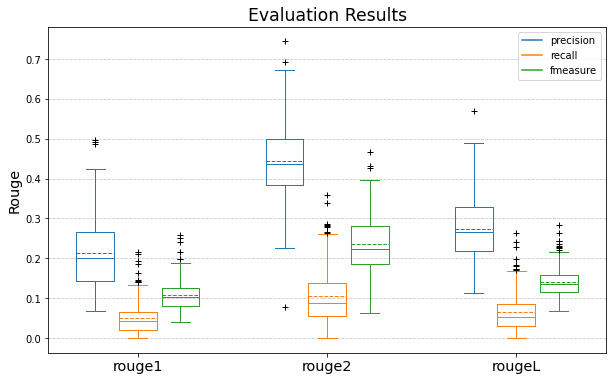

In [24]:
plot_evaluation('facebook/bart-base')